In [2]:
from sklearn import preprocessing
from sklearn.utils import shuffle
import pandas as pd
import numpy as np
import sys
from sklearn.externals import joblib
import operator
from sklearn.metrics import make_scorer
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, fbeta_score, precision_score, recall_score, accuracy_score, roc_auc_score, average_precision_score

In [169]:
trainset_robust_scaled = pd.read_csv('trainset_robust_scaled.csv')

In [170]:
trainset_robust_scaled.shape

(4422530, 77)

In [97]:
testset_robust_scaled = pd.read_csv('testset_robust_scaled.csv')

In [98]:
# Since dropping the coupon_based features drops the AUC score the most, let's check why
# first, we look at the model that includes coupon based features and see what features in the set are important. 
# Try dropping it from the model and check auc and recall since they drop the most
# next, we can look at the feature distributions in the correct and error class. 


clf_all_features = joblib.load('clf_group9.pkl')
clf_group1 = joblib.load('clf_group5.pkl')
clf_group2 = joblib.load('clf_group6.pkl')
clf_group3 = joblib.load('clf_group7.pkl')

In [85]:
coupon_based_features = ['coupon_effective_days', 'money', 'max_money', 'type1', 'type6', 
               'Complaints', 'Eventsoperation', 'NewUserCouponPackageByBD', 'PreUserCouponCode', 'RecallUserDaily', 'home201603222253', 
               'home_dongbeiguan', 'home_jiangzhecai', 'home_muqinjie', 'home_xiangcaiguan', 'preuser', 'shareuser', 
               '商家拒单返券', '家厨发券', '活动赠券', '码兑券', '自运营赠券', '蒲公英受邀', 'covers_mon', 'covers_tue', 'covers_wed', 'covers_thu', 'covers_fri', 'covers_sat', 'covers_sun']

In [86]:
feature_analysis = pd.read_csv("feature_set_analysis.csv")
feature_analysis.sort_values(by='sorted_feature_importances', inplace=True)
feature_list = [i[0] for i in eval(feature_analysis.loc[7, 'sorted_feature_importances'])]
drop_feature_order = dict()

In [95]:
feature_list

['Recency_fillna_w_start_date',
 'user_longitude_median',
 'user_latitude_median',
 'worth_money_median',
 'distance_median',
 'money',
 'coupon_usage_rate',
 'InterOrder_fillna_w_start_date',
 'kitchen_entropy',
 'coupon_type1_usage_rate',
 'worth_money_std',
 'distance_std',
 'InterCoup_fillna_w_start_date',
 'order_coupon_usage_rate',
 'coupon_effective_days',
 'order_weekend_perc',
 'BiWeeklyOrderCount',
 'WeeklyOrderCount',
 'max_money',
 'age_0',
 'user_longitude_std',
 'coupon_used_weekend_perc',
 'user_latitude_std',
 'BiWeeklyCouponUsedCount',
 'coupon_type6_usage_rate',
 'WeeklyCouponUsedCount',
 'city1',
 'city2',
 'covers_sun',
 'covers_wed',
 'covers_sat',
 'covers_thu',
 'city4',
 'sex_2',
 'type1',
 'AppVerLast_2.7',
 'covers_mon',
 'covers_tue',
 'covers_fri',
 '\xe6\xb4\xbb\xe5\x8a\xa8\xe8\xb5\xa0\xe5\x88\xb8',
 'age_80',
 'age_90',
 'sex_1',
 'shareuser',
 'city5',
 'age_70',
 'CoupUseLast',
 'city3',
 '\xe7\xa0\x81\xe5\x85\x91\xe5\x88\xb8',
 '\xe5\xae\xb6\xe5\x8e\xa8

In [92]:
drop_feature_order

{'Complaints': 65,
 'Eventsoperation': 71,
 'NewUserCouponPackageByBD': 70,
 'PreUserCouponCode': 63,
 'RecallUserDaily': 50,
 'coupon_effective_days': 14,
 'covers_fri': 38,
 'covers_mon': 36,
 'covers_sat': 30,
 'covers_sun': 28,
 'covers_thu': 31,
 'covers_tue': 37,
 'covers_wed': 29,
 'home201603222253': 60,
 'home_dongbeiguan': 64,
 'home_jiangzhecai': 57,
 'home_muqinjie': 54,
 'home_xiangcaiguan': 69,
 'max_money': 18,
 'money': 5,
 'preuser': 56,
 'shareuser': 43,
 'type1': 34,
 'type6': 51,
 '\xe5\x95\x86\xe5\xae\xb6\xe6\x8b\x92\xe5\x8d\x95\xe8\xbf\x94\xe5\x88\xb8': 61,
 '\xe5\xae\xb6\xe5\x8e\xa8\xe5\x8f\x91\xe5\x88\xb8': 49,
 '\xe6\xb4\xbb\xe5\x8a\xa8\xe8\xb5\xa0\xe5\x88\xb8': 39,
 '\xe7\xa0\x81\xe5\x85\x91\xe5\x88\xb8': 48,
 '\xe8\x87\xaa\xe8\xbf\x90\xe8\x90\xa5\xe8\xb5\xa0\xe5\x88\xb8': 53,
 '\xe8\x92\xb2\xe5\x85\xac\xe8\x8b\xb1\xe5\x8f\x97\xe9\x82\x80': 59}

In [93]:
for feature in coupon_based_features:
    if feature in feature_list:
        rank = feature_list.index(feature)
        drop_feature_order[rank] = feature

In [94]:
drop_feature_order

{5: 'money',
 14: 'coupon_effective_days',
 18: 'max_money',
 28: 'covers_sun',
 29: 'covers_wed',
 30: 'covers_sat',
 31: 'covers_thu',
 34: 'type1',
 36: 'covers_mon',
 37: 'covers_tue',
 38: 'covers_fri',
 39: '\xe6\xb4\xbb\xe5\x8a\xa8\xe8\xb5\xa0\xe5\x88\xb8',
 43: 'shareuser',
 48: '\xe7\xa0\x81\xe5\x85\x91\xe5\x88\xb8',
 49: '\xe5\xae\xb6\xe5\x8e\xa8\xe5\x8f\x91\xe5\x88\xb8',
 50: 'RecallUserDaily',
 51: 'type6',
 53: '\xe8\x87\xaa\xe8\xbf\x90\xe8\x90\xa5\xe8\xb5\xa0\xe5\x88\xb8',
 54: 'home_muqinjie',
 56: 'preuser',
 57: 'home_jiangzhecai',
 59: '\xe8\x92\xb2\xe5\x85\xac\xe8\x8b\xb1\xe5\x8f\x97\xe9\x82\x80',
 60: 'home201603222253',
 61: '\xe5\x95\x86\xe5\xae\xb6\xe6\x8b\x92\xe5\x8d\x95\xe8\xbf\x94\xe5\x88\xb8',
 63: 'PreUserCouponCode',
 64: 'home_dongbeiguan',
 65: 'Complaints',
 69: 'home_xiangcaiguan',
 70: 'NewUserCouponPackageByBD',
 71: 'Eventsoperation',
 'Complaints': 65,
 'Eventsoperation': 71,
 'NewUserCouponPackageByBD': 70,
 'PreUserCouponCode': 63,
 'RecallUserDai

In [88]:
check_features = sorted(drop_feature_order, key=drop_feature_order.get)
results_list = list()

In [91]:
drop_feature_order

{'Complaints': 65,
 'Eventsoperation': 71,
 'NewUserCouponPackageByBD': 70,
 'PreUserCouponCode': 63,
 'RecallUserDaily': 50,
 'coupon_effective_days': 14,
 'covers_fri': 38,
 'covers_mon': 36,
 'covers_sat': 30,
 'covers_sun': 28,
 'covers_thu': 31,
 'covers_tue': 37,
 'covers_wed': 29,
 'home201603222253': 60,
 'home_dongbeiguan': 64,
 'home_jiangzhecai': 57,
 'home_muqinjie': 54,
 'home_xiangcaiguan': 69,
 'max_money': 18,
 'money': 5,
 'preuser': 56,
 'shareuser': 43,
 'type1': 34,
 'type6': 51,
 '\xe5\x95\x86\xe5\xae\xb6\xe6\x8b\x92\xe5\x8d\x95\xe8\xbf\x94\xe5\x88\xb8': 61,
 '\xe5\xae\xb6\xe5\x8e\xa8\xe5\x8f\x91\xe5\x88\xb8': 49,
 '\xe6\xb4\xbb\xe5\x8a\xa8\xe8\xb5\xa0\xe5\x88\xb8': 39,
 '\xe7\xa0\x81\xe5\x85\x91\xe5\x88\xb8': 48,
 '\xe8\x87\xaa\xe8\xbf\x90\xe8\x90\xa5\xe8\xb5\xa0\xe5\x88\xb8': 53,
 '\xe8\x92\xb2\xe5\x85\xac\xe8\x8b\xb1\xe5\x8f\x97\xe9\x82\x80': 59}

In [46]:
feature_analysis.sort_values(by='sorted_feature_importances', inplace=True)
feature_analysis

,feature_set,cmatrix,F0.5,precision,recall,accuracy,roc,avg_precision,sorted_feature_importances
7,y_testset_all_features,[[ 58923 108032]\n [ 38477 856566]],0.529355,0.604959,0.352927,0.862044,0.862909,0.315232,"[('Recency_fillna_w_start_date', 0.058043838),..."
4,y_testset_group2,[[ 8668 158287]\n [ 5750 889293]],0.192942,0.601193,0.051918,0.845539,0.748035,0.180259,"[('Recency_fillna_w_start_date', 0.10207727), ..."
1,y_devset4_group2,[[ 3082 91414]\n [ 2247 908278]],0.133060,0.578345,0.032615,0.906807,0.777286,0.109820,"[('Recency_fillna_w_start_date', 0.1067607), (..."
5,y_testset_group3,[[ 54265 112690]\n [ 39117 855926]],0.502005,0.581108,0.325028,0.857055,0.829880,0.294987,"[('Recency_fillna_w_start_date', 0.14804149), ..."
8,y_devset_all_features,[[ 28794 65702]\n [ 14794 895731]],0.535507,0.660595,0.304711,0.919906,0.889638,0.266664,"[('coupon_effective_days', 0.14064637), ('user..."
0,y_devset4_group1,[[ 28960 65536]\n [ 16169 894356]],0.526522,0.641716,0.306468,0.918703,0.877911,0.261874,"[('coupon_effective_days', 0.15271597), ('user..."
2,y_devset4_group3,[[ 26231 68265]\n [ 15345 895180]],0.502895,0.630917,0.277588,0.916808,0.869388,0.243059,"[('coupon_effective_days', 0.1573529), ('Recen..."
3,y_testset_group1,[[ 57929 109026]\n [ 38161 856882]],0.525371,0.602862,0.346974,0.861406,0.841286,0.311838,"[('user_latitude_median', 0.07284116), ('user_..."
6,testset_stratified_random_baseline,[[ 14671 152284]\n [ 78752 816291]],0.135680,0.157038,0.087874,0.782452,0.499944,0.157193,no feature importance


In [47]:
feature_list = [i[0] for i in eval(feature_analysis.loc[7, 'sorted_feature_importances'])]

In [48]:
tmp = feature_analysis[feature_analysis['feature_set']=='y_testset_all_features']
feature_list = tmp.loc[7, 'sorted_feature_importances']
feature_list

"[('Recency_fillna_w_start_date', 0.058043838), ('user_longitude_median', 0.05343065), ('user_latitude_median', 0.052347742), ('worth_money_median', 0.04815689), ('distance_median', 0.04628346), ('money', 0.04627263), ('coupon_usage_rate', 0.04358702), ('InterOrder_fillna_w_start_date', 0.040847268), ('kitchen_entropy', 0.037381962), ('coupon_type1_usage_rate', 0.03708958), ('worth_money_std', 0.03610413), ('distance_std', 0.035356928), ('InterCoup_fillna_w_start_date', 0.03332106), ('order_coupon_usage_rate', 0.031296022), ('coupon_effective_days', 0.02889197), ('order_weekend_perc', 0.026108896), ('BiWeeklyOrderCount', 0.025220914), ('WeeklyOrderCount', 0.022145456), ('max_money', 0.020553581), ('age_0', 0.017835485), ('user_longitude_std', 0.017618904), ('coupon_used_weekend_perc', 0.01577796), ('user_latitude_std', 0.01520402), ('BiWeeklyCouponUsedCount', 0.014792515), ('coupon_type6_usage_rate', 0.013763753), ('WeeklyCouponUsedCount', 0.01310318), ('city1', 0.011782032), ('city2',

In [33]:
drop_feature_order = dict()
for feature in coupon_based_features:
    if feature in feature_list:
        rank = feature_list.index(feature)
        drop_feature_order[feature] = rank

In [83]:
for feature in coupon_based_features:
    if feature in feature_list:
        rank = feature_list.index(feature)
        drop_feature_order[rank] = feature

In [84]:
drop_feature_order

{133: 'money',
 344: 'type1',
 531: 'coupon_effective_days',
 679: 'max_money',
 894: 'type6',
 1015: 'covers_sun',
 1044: 'covers_wed',
 1073: 'covers_sat',
 1102: 'covers_thu',
 1240: 'covers_mon',
 1269: 'covers_tue',
 1298: 'covers_fri',
 1471: 'shareuser',
 1729: 'RecallUserDaily',
 1892: 'home_muqinjie',
 1959: 'preuser',
 1986: 'home_jiangzhecai',
 2133: 'home201603222253',
 2296: 'PreUserCouponCode',
 2334: 'home_dongbeiguan',
 2369: 'Complaints',
 2484: 'home_xiangcaiguan',
 2512: 'NewUserCouponPackageByBD',
 2547: 'Eventsoperation',
 'Complaints': 65,
 'Eventsoperation': 71,
 'NewUserCouponPackageByBD': 70,
 'PreUserCouponCode': 63,
 'RecallUserDaily': 50,
 'coupon_effective_days': 14,
 'covers_fri': 38,
 'covers_mon': 36,
 'covers_sat': 30,
 'covers_sun': 28,
 'covers_thu': 31,
 'covers_tue': 37,
 'covers_wed': 29,
 'home201603222253': 60,
 'home_dongbeiguan': 64,
 'home_jiangzhecai': 57,
 'home_muqinjie': 54,
 'home_xiangcaiguan': 69,
 'max_money': 18,
 'money': 5,
 'preuse

In [49]:
check_features = sorted(drop_feature_order, key=drop_feature_order.get)

In [51]:
len(check_features)

30

In [ ]:
for i in xrange(0, 10):

    feature = check_features[i: 10]
    print ("feature: ", feature)

In [50]:
check_features

['money',
 'coupon_effective_days',
 'max_money',
 'covers_sun',
 'covers_wed',
 'covers_sat',
 'covers_thu',
 'type1',
 'covers_mon',
 'covers_tue',
 'covers_fri',
 '\xe6\xb4\xbb\xe5\x8a\xa8\xe8\xb5\xa0\xe5\x88\xb8',
 'shareuser',
 '\xe7\xa0\x81\xe5\x85\x91\xe5\x88\xb8',
 '\xe5\xae\xb6\xe5\x8e\xa8\xe5\x8f\x91\xe5\x88\xb8',
 'RecallUserDaily',
 'type6',
 '\xe8\x87\xaa\xe8\xbf\x90\xe8\x90\xa5\xe8\xb5\xa0\xe5\x88\xb8',
 'home_muqinjie',
 'preuser',
 'home_jiangzhecai',
 '\xe8\x92\xb2\xe5\x85\xac\xe8\x8b\xb1\xe5\x8f\x97\xe9\x82\x80',
 'home201603222253',
 '\xe5\x95\x86\xe5\xae\xb6\xe6\x8b\x92\xe5\x8d\x95\xe8\xbf\x94\xe5\x88\xb8',
 'PreUserCouponCode',
 'home_dongbeiguan',
 'Complaints',
 'home_xiangcaiguan',
 'NewUserCouponPackageByBD',
 'Eventsoperation']

In [101]:
# X_trainset= trainset_robust_scaled[trainset_robust_scaled.columns[5:]]
# y_trainset = trainset_robust_scaled['is_used']

X_testset= testset_robust_scaled[testset_robust_scaled.columns[5:]]
y_testset = testset_robust_scaled['is_used']

In [163]:
clf = XGBClassifier(random_state=42, n_jobs=-1, n_estimators=500, learning_rate=0.05, max_depth=8)

In [166]:
#X_trainset.columns

X_trainset.rename(columns={'商家拒单返券': 'shangjiafangquan', '家厨发券': 'jiachufaquan', '活动赠券': 'huodongzhengquan' , '码兑券':'matuiquan', '自运营赠券':'zhiyunying', '蒲公英受邀':'pugongying' }, inplace=True)

/Users/Phoebe/anaconda/envs/py27/lib/python2.7/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [184]:
X_testset.rename(columns={'商家拒单返券': 'shangjiafangquan', '家厨发券': 'jiachufaquan', '活动赠券': 'huodongzhengquan' , '码兑券':'matuiquan', '自运营赠券':'zhiyunying', '蒲公英受邀':'pugongying' }, inplace=True)

In [185]:
X_testset.columns

Index([u'sex_1', u'sex_2', u'age_60', u'age_70', u'age_80', u'age_90',
       u'age_0', u'city1', u'city2', u'city3', u'city4', u'city5',
       u'AppVerLast_2.1', u'AppVerLast_2.2', u'AppVerLast_2.3',
       u'AppVerLast_2.4', u'AppVerLast_2.5', u'AppVerLast_2.7',
       u'AppVerLast_2.8', u'covers_mon', u'covers_tue', u'covers_wed',
       u'covers_thu', u'covers_fri', u'covers_sat', u'covers_sun', u'type1',
       u'type6', u'Complaints', u'Eventsoperation',
       u'NewUserCouponPackageByBD', u'PreUserCouponCode', u'RecallUserDaily',
       u'home201603222253', u'home_dongbeiguan', u'home_jiangzhecai',
       u'home_muqinjie', u'home_xiangcaiguan', u'preuser', u'shareuser',
       u'shangjiafangquan', u'jiachufaquan', u'huodongzhengquan', u'matuiquan',
       u'zhiyunying', u'pugongying', u'CoupUseLast', u'kitchen_entropy',
       u'distance_median', u'distance_std', u'user_longitude_median',
       u'user_longitude_std', u'user_latitude_median', u'user_latitude_std',
       u'coup

In [167]:
clf.fit(X_trainset, y_trainset)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [ ]:
clf.fit(X_trainset, y_trainset)

In [11]:
X_testset.drop(['Recency', 'InterOrder', 'InterCoup'], axis=1, inplace=True)

/Users/Phoebe/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [55]:
len(X_testset.columns)

72

In [4]:
feature_analysis

,feature_set,cmatrix,F0.5,precision,recall,accuracy,roc,avg_precision,sorted_feature_importances
0,y_devset4_group1,[[ 28960 65536]\n [ 16169 894356]],0.526522,0.641716,0.306468,0.918703,0.877911,0.261874,"[('coupon_effective_days', 0.15271597), ('user..."
1,y_devset4_group2,[[ 3082 91414]\n [ 2247 908278]],0.133060,0.578345,0.032615,0.906807,0.777286,0.109820,"[('Recency_fillna_w_start_date', 0.1067607), (..."
2,y_devset4_group3,[[ 26231 68265]\n [ 15345 895180]],0.502895,0.630917,0.277588,0.916808,0.869388,0.243059,"[('coupon_effective_days', 0.1573529), ('Recen..."
3,y_testset_group1,[[ 57929 109026]\n [ 38161 856882]],0.525371,0.602862,0.346974,0.861406,0.841286,0.311838,"[('user_latitude_median', 0.07284116), ('user_..."
4,y_testset_group2,[[ 8668 158287]\n [ 5750 889293]],0.192942,0.601193,0.051918,0.845539,0.748035,0.180259,"[('Recency_fillna_w_start_date', 0.10207727), ..."
5,y_testset_group3,[[ 54265 112690]\n [ 39117 855926]],0.502005,0.581108,0.325028,0.857055,0.829880,0.294987,"[('Recency_fillna_w_start_date', 0.14804149), ..."
6,testset_stratified_random_baseline,[[ 14671 152284]\n [ 78752 816291]],0.135680,0.157038,0.087874,0.782452,0.499944,0.157193,no feature importance
7,y_testset_all_features,[[ 58923 108032]\n [ 38477 856566]],0.529355,0.604959,0.352927,0.862044,0.862909,0.315232,"[('Recency_fillna_w_start_date', 0.058043838),..."
8,y_devset_all_features,[[ 28794 65702]\n [ 14794 895731]],0.535507,0.660595,0.304711,0.919906,0.889638,0.266664,"[('coupon_effective_days', 0.14064637), ('user..."


In [40]:
feature_analysis.loc[3, 'sorted_feature_importances']

"[('user_latitude_median', 0.07284116), ('user_longitude_median', 0.07110659), ('distance_median', 0.07060335), ('coupon_usage_rate', 0.06735907), ('kitchen_entropy', 0.06639542), ('order_coupon_usage_rate', 0.061288077), ('coupon_type1_usage_rate', 0.06051716), ('distance_std', 0.059028856), ('money', 0.050805718), ('order_weekend_perc', 0.04181166), ('coupon_effective_days', 0.03523743), ('coupon_type6_usage_rate', 0.031072328), ('user_longitude_std', 0.026200546), ('coupon_used_weekend_perc', 0.024476685), ('user_latitude_std', 0.023373842), ('max_money', 0.022838483), ('age_0', 0.020279458), ('AppVerLast_2.7', 0.013833717), ('city1', 0.013673109), ('city2', 0.011317522), ('covers_sat', 0.00898335), ('covers_thu', 0.008844157), ('sex_2', 0.008833449), ('covers_sun', 0.00871567), ('covers_wed', 0.007859093), ('city4', 0.007644949), ('age_90', 0.00752717), ('covers_mon', 0.0073237326), ('age_80', 0.007045345), ('covers_fri', 0.007045345), ('type1', 0.006991809), ('sex_1', 0.006884737)

In [11]:
feature_analysis.loc[2, 'sorted_feature_importances']

"[('coupon_effective_days', 0.1573529), ('Recency_fillna_w_start_date', 0.1374858), ('InterOrder_fillna_w_start_date', 0.110095374), ('worth_money_median', 0.098268084), ('worth_money_std', 0.08650966), ('InterCoup_fillna_w_start_date', 0.07371828), ('money', 0.06869125), ('BiWeeklyOrderCount', 0.04835933), ('WeeklyOrderCount', 0.035912268), ('BiWeeklyCouponUsedCount', 0.026598493), ('WeeklyCouponUsedCount', 0.023551285), ('CoupUseLast', 0.018575905), ('max_money', 0.0158558), ('covers_thu', 0.013290638), ('covers_sun', 0.0112247355), ('covers_fri', 0.010209001), ('covers_tue', 0.008229177), ('covers_wed', 0.008125883), ('type1', 0.0076438384), ('covers_sat', 0.0070412834), ('covers_mon', 0.0057673105), ('\\xe5\\xae\\xb6\\xe5\\x8e\\xa8\\xe5\\x8f\\x91\\xe5\\x88\\xb8', 0.0044589057), ('\\xe6\\xb4\\xbb\\xe5\\x8a\\xa8\\xe8\\xb5\\xa0\\xe5\\x88\\xb8', 0.0042867474), ('\\xe8\\x87\\xaa\\xe8\\xbf\\x90\\xe8\\x90\\xa5\\xe8\\xb5\\xa0\\xe5\\x88\\xb8', 0.003598113), ('shareuser', 0.002926695), ('\\x

In [22]:
feature_analysis.loc[3, 'sorted_feature_importances']

"[('user_latitude_median', 0.07284116), ('user_longitude_median', 0.07110659), ('distance_median', 0.07060335), ('coupon_usage_rate', 0.06735907), ('kitchen_entropy', 0.06639542), ('order_coupon_usage_rate', 0.061288077), ('coupon_type1_usage_rate', 0.06051716), ('distance_std', 0.059028856), ('money', 0.050805718), ('order_weekend_perc', 0.04181166), ('coupon_effective_days', 0.03523743), ('coupon_type6_usage_rate', 0.031072328), ('user_longitude_std', 0.026200546), ('coupon_used_weekend_perc', 0.024476685), ('user_latitude_std', 0.023373842), ('max_money', 0.022838483), ('age_0', 0.020279458), ('AppVerLast_2.7', 0.013833717), ('city1', 0.013673109), ('city2', 0.011317522), ('covers_sat', 0.00898335), ('covers_thu', 0.008844157), ('sex_2', 0.008833449), ('covers_sun', 0.00871567), ('covers_wed', 0.007859093), ('city4', 0.007644949), ('age_90', 0.00752717), ('covers_mon', 0.0073237326), ('age_80', 0.007045345), ('covers_fri', 0.007045345), ('type1', 0.006991809), ('sex_1', 0.006884737)

In [23]:
feature_analysis.loc[5, 'sorted_feature_importances']

"[('Recency_fillna_w_start_date', 0.14804149), ('worth_money_median', 0.115238994), ('worth_money_std', 0.1050506), ('InterOrder_fillna_w_start_date', 0.10179215), ('InterCoup_fillna_w_start_date', 0.0842034), ('money', 0.061520457), ('BiWeeklyOrderCount', 0.058824204), ('WeeklyOrderCount', 0.050987862), ('coupon_effective_days', 0.042864684), ('BiWeeklyCouponUsedCount', 0.04043232), ('WeeklyCouponUsedCount', 0.032240298), ('max_money', 0.022522315), ('CoupUseLast', 0.019826064), ('covers_thu', 0.01192088), ('covers_wed', 0.011656991), ('covers_sun', 0.010980059), ('covers_sat', 0.010785012), ('covers_fri', 0.009132839), ('covers_mon', 0.008708322), ('covers_tue', 0.008639483), ('type1', 0.007641295), ('\\xe6\\xb4\\xbb\\xe5\\x8a\\xa8\\xe8\\xb5\\xa0\\xe5\\x88\\xb8', 0.005782602), ('shareuser', 0.005656394), ('\\xe7\\xa0\\x81\\xe5\\x85\\x91\\xe5\\x88\\xb8', 0.0041304296), ('\\xe5\\xae\\xb6\\xe5\\x8e\\xa8\\xe5\\x8f\\x91\\xe5\\x88\\xb8', 0.003809174), ('\\xe8\\x87\\xaa\\xe8\\xbf\\x90\\xe8\

In [ ]:
# Coupon_based features:
# Coupon Effective Days, Money, Max_Money, 'type1', 0.007641295), ('\\xe6\\xb4\\xbb\\xe5\\x8a\\xa8\\xe8\\xb5\\xa0\\xe5\\x88\\xb8', 0.005782602

In [26]:
clf_rf = RandomForestClassifier(n_jobs=-1, random_state=0, max_features=8, n_estimators=300, max_depth=8, class_weight={1: 3})

In [35]:
X_trainset.columns

Index([u'sex_1', u'sex_2', u'age_60', u'age_70', u'age_80', u'age_90',
       u'age_0', u'city1', u'city2', u'city3', u'city4', u'city5',
       u'AppVerLast_2.1', u'AppVerLast_2.2', u'AppVerLast_2.3',
       u'AppVerLast_2.4', u'AppVerLast_2.5', u'AppVerLast_2.7',
       u'AppVerLast_2.8', u'covers_mon', u'covers_tue', u'covers_wed',
       u'covers_thu', u'covers_fri', u'covers_sat', u'covers_sun', u'type1',
       u'type6', u'Complaints', u'Eventsoperation',
       u'NewUserCouponPackageByBD', u'PreUserCouponCode', u'RecallUserDaily',
       u'home201603222253', u'home_dongbeiguan', u'home_jiangzhecai',
       u'home_muqinjie', u'home_xiangcaiguan', u'preuser', u'shareuser',
       u'商家拒单返券', u'家厨发券', u'活动赠券', u'码兑券', u'自运营赠券', u'蒲公英受邀', u'CoupUseLast',
       u'kitchen_entropy', u'distance_median', u'distance_std',
       u'user_longitude_median', u'user_longitude_std',
       u'user_latitude_median', u'user_latitude_std', u'money', u'max_money',
       u'WeeklyCouponUsedCount', u'

In [41]:
X_testset.columns

Index([u'sex_1', u'sex_2', u'age_60', u'age_70', u'age_80', u'age_90',
       u'age_0', u'city1', u'city2', u'city3', u'city4', u'city5',
       u'AppVerLast_2.1', u'AppVerLast_2.2', u'AppVerLast_2.3',
       u'AppVerLast_2.4', u'AppVerLast_2.5', u'AppVerLast_2.7',
       u'AppVerLast_2.8', u'covers_mon', u'covers_tue', u'covers_wed',
       u'covers_thu', u'covers_fri', u'covers_sat', u'covers_sun', u'type1',
       u'type6', u'Complaints', u'Eventsoperation',
       u'NewUserCouponPackageByBD', u'PreUserCouponCode', u'RecallUserDaily',
       u'home201603222253', u'home_dongbeiguan', u'home_jiangzhecai',
       u'home_muqinjie', u'home_xiangcaiguan', u'preuser', u'shareuser',
       u'商家拒单返券', u'家厨发券', u'活动赠券', u'码兑券', u'自运营赠券', u'蒲公英受邀', u'CoupUseLast',
       u'kitchen_entropy', u'distance_median', u'distance_std',
       u'user_longitude_median', u'user_longitude_std',
       u'user_latitude_median', u'user_latitude_std', u'coupon_effective_days',
       u'money', u'max_money', u'

In [61]:
check_feature_list = ['coupon_effective_days', 'money', 'max_money', 'type1', 'type6', 'shareuser', '活动赠券']
results_list = list()

for i in xrange(1, len(check_feature_list)):
    
    feature = check_feature_list[:i+1]
    print ("feature: ", feature)

    X_train = X_trainset.drop(feature, axis=1)
    print ("done")
    clf_rf.fit(X_train, y_trainset)

    X_test = X_testset.drop(feature, axis=1)
    y_pred_class = clf_rf.predict(X_test)

    if clf_rf.classes_[1] == 1:
        y_pred_prob = clf_rf.predict_proba(X_test)[:, 1]
    else:
        y_pred_prob = clf_rf.predict_proba(X_test)[:, 0]

    recall = recall_score(y_testset, y_pred_class, labels=[1,0])
    print("Recall: {}".format(recall))

    roc = roc_auc_score(y_testset, y_pred_prob)
    print("Roc: {}".format(roc))
    
    results = [feature, recall, roc]
    results_list.append(results)
    
final_df = pd.DataFrame(results_list, columns = ["params", "recall", "roc"])
final_df.to_csv("results_list.csv", index=False, header=True)

('feature: ', ['coupon_effective_days', 'money'])
done
Recall: 0.554951933156
Roc: 0.838629880859
('feature: ', ['coupon_effective_days', 'money', 'max_money'])
done
Recall: 0.621448893414
Roc: 0.82937546202
('feature: ', ['coupon_effective_days', 'money', 'max_money', 'type1'])
done
Recall: 0.625300230601
Roc: 0.832484207415
('feature: ', ['coupon_effective_days', 'money', 'max_money', 'type1', 'type6'])
done
Recall: 0.552681860382
Roc: 0.826392864209
('feature: ', ['coupon_effective_days', 'money', 'max_money', 'type1', 'type6', 'shareuser'])
done
Recall: 0.553951663622
Roc: 0.826065519451
('feature: ', ['coupon_effective_days', 'money', 'max_money', 'type1', 'type6', 'shareuser', '\xe6\xb4\xbb\xe5\x8a\xa8\xe8\xb5\xa0\xe5\x88\xb8'])
done
Recall: 0.362828307029
Roc: 0.774559716425


In [45]:
# Dropping Coupon Effective Days. 

Recall: 0.564906711389
Roc: 0.844271266785

71

In [75]:
coupon_based_features = ['coupon_effective_days', 'money', 'max_money', 'type1', 'type6', '活动赠券', 'shareuser',
               '商家拒单返券', '家厨发券', '码兑券', '自运营赠券', '蒲公英受邀', 
               'covers_mon', 'covers_tue', 'covers_wed', 'covers_thu', 'covers_fri', 'covers_sat', 'covers_sun',
               'Complaints', 'PreUserCouponCode', 'RecallUserDaily', 'home201603222253', 
               'home_dongbeiguan', 'home_jiangzhecai', 'home_muqinjie', 'preuser']

In [64]:
check_feature_list = coupon_based_features
results_list = list()

for i in xrange(19, len(check_feature_list)):
    
    feature = check_feature_list[:i+1]
    print ("feature: ", feature)

    X_train = X_trainset.drop(feature, axis=1)
    print ("done")
    clf_rf.fit(X_train, y_trainset)

    X_test = X_testset.drop(feature, axis=1)
    y_pred_class = clf_rf.predict(X_test)

    if clf_rf.classes_[1] == 1:
        y_pred_prob = clf_rf.predict_proba(X_test)[:, 1]
    else:
        y_pred_prob = clf_rf.predict_proba(X_test)[:, 0]

    recall = recall_score(y_testset, y_pred_class, labels=[1,0])
    print("Recall: {}".format(recall))

    roc = roc_auc_score(y_testset, y_pred_prob)
    print("Roc: {}".format(roc))
    
    results = [feature, recall, roc]
    results_list.append(results)
    
final_df = pd.DataFrame(results_list, columns = ["params", "recall", "roc"])
final_df.to_csv("results_list2.csv", index=False, header=True)

('feature: ', ['coupon_effective_days', 'money', 'max_money', 'type1', 'type6', '\xe6\xb4\xbb\xe5\x8a\xa8\xe8\xb5\xa0\xe5\x88\xb8', 'shareuser', '\xe5\x95\x86\xe5\xae\xb6\xe6\x8b\x92\xe5\x8d\x95\xe8\xbf\x94\xe5\x88\xb8'])
done
Recall: 0.362079602288
Roc: 0.773839751655
('feature: ', ['coupon_effective_days', 'money', 'max_money', 'type1', 'type6', '\xe6\xb4\xbb\xe5\x8a\xa8\xe8\xb5\xa0\xe5\x88\xb8', 'shareuser', '\xe5\x95\x86\xe5\xae\xb6\xe6\x8b\x92\xe5\x8d\x95\xe8\xbf\x94\xe5\x88\xb8', '\xe5\xae\xb6\xe5\x8e\xa8\xe5\x8f\x91\xe5\x88\xb8'])
done
Recall: 0.365224162199
Roc: 0.775100432981
('feature: ', ['coupon_effective_days', 'money', 'max_money', 'type1', 'type6', '\xe6\xb4\xbb\xe5\x8a\xa8\xe8\xb5\xa0\xe5\x88\xb8', 'shareuser', '\xe5\x95\x86\xe5\xae\xb6\xe6\x8b\x92\xe5\x8d\x95\xe8\xbf\x94\xe5\x88\xb8', '\xe5\xae\xb6\xe5\x8e\xa8\xe5\x8f\x91\xe5\x88\xb8', '\xe7\xa0\x81\xe5\x85\x91\xe5\x88\xb8'])
done
Recall: 0.362313198167
Roc: 0.77613471388
('feature: ', ['coupon_effective_days', 'money'

ValueError: labels ['covers_sunComplaints'] not contained in axis

In [65]:
coupon_based_features = ['coupon_effective_days', 'money', 'max_money', 'type1', 'type6', '活动赠券', 'shareuser',
               '商家拒单返券', '家厨发券', '码兑券', '自运营赠券', '蒲公英受邀', 
               'covers_mon', 'covers_tue', 'covers_wed', 'covers_thu', 'covers_fri', 'covers_sat', 'covers_sun',
               'Complaints', 'PreUserCouponCode', 'RecallUserDaily', 'home201603222253', 
               'home_dongbeiguan', 'home_jiangzhecai', 'home_muqinjie', 'preuser']

In [66]:
check_feature_list = coupon_based_features
results_list = list()

for i in xrange(19, len(check_feature_list)):
    
    feature = check_feature_list[:i+1]
    print ("feature: ", feature)

    X_train = X_trainset.drop(feature, axis=1)
    print ("done")
    clf_rf.fit(X_train, y_trainset)

    X_test = X_testset.drop(feature, axis=1)
    y_pred_class = clf_rf.predict(X_test)

    if clf_rf.classes_[1] == 1:
        y_pred_prob = clf_rf.predict_proba(X_test)[:, 1]
    else:
        y_pred_prob = clf_rf.predict_proba(X_test)[:, 0]

    recall = recall_score(y_testset, y_pred_class, labels=[1,0])
    print("Recall: {}".format(recall))

    roc = roc_auc_score(y_testset, y_pred_prob)
    print("Roc: {}".format(roc))
    
    results = [feature, recall, roc]
    results_list.append(results)
    
final_df = pd.DataFrame(results_list, columns = ["params", "recall", "roc"])
final_df.to_csv("results_list3.csv", index=False, header=True)

('feature: ', ['coupon_effective_days', 'money', 'max_money', 'type1', 'type6', '\xe6\xb4\xbb\xe5\x8a\xa8\xe8\xb5\xa0\xe5\x88\xb8', 'shareuser', '\xe5\x95\x86\xe5\xae\xb6\xe6\x8b\x92\xe5\x8d\x95\xe8\xbf\x94\xe5\x88\xb8', '\xe5\xae\xb6\xe5\x8e\xa8\xe5\x8f\x91\xe5\x88\xb8', '\xe7\xa0\x81\xe5\x85\x91\xe5\x88\xb8', '\xe8\x87\xaa\xe8\xbf\x90\xe8\x90\xa5\xe8\xb5\xa0\xe5\x88\xb8', '\xe8\x92\xb2\xe5\x85\xac\xe8\x8b\xb1\xe5\x8f\x97\xe9\x82\x80', 'covers_mon', 'covers_tue', 'covers_wed', 'covers_thu', 'covers_fri', 'covers_sat', 'covers_sun', 'Complaints'])
done
Recall: 0.258997933575
Roc: 0.72522050257
('feature: ', ['coupon_effective_days', 'money', 'max_money', 'type1', 'type6', '\xe6\xb4\xbb\xe5\x8a\xa8\xe8\xb5\xa0\xe5\x88\xb8', 'shareuser', '\xe5\x95\x86\xe5\xae\xb6\xe6\x8b\x92\xe5\x8d\x95\xe8\xbf\x94\xe5\x88\xb8', '\xe5\xae\xb6\xe5\x8e\xa8\xe5\x8f\x91\xe5\x88\xb8', '\xe7\xa0\x81\xe5\x85\x91\xe5\x88\xb8', '\xe8\x87\xaa\xe8\xbf\x90\xe8\x90\xa5\xe8\xb5\xa0\xe5\x88\xb8', '\xe8\x92\xb2\xe5\x85\

In [5]:
read_results1 = pd.read_csv("results_list.csv")

In [73]:
read_results

,params,recall,roc
0,"['coupon_effective_days', 'money', 'max_money'...",0.258998,0.725221
1,"['coupon_effective_days', 'money', 'max_money'...",0.258884,0.725499
2,"['coupon_effective_days', 'money', 'max_money'...",0.238609,0.721278
3,"['coupon_effective_days', 'money', 'max_money'...",0.237303,0.721609
4,"['coupon_effective_days', 'money', 'max_money'...",0.238579,0.722077
5,"['coupon_effective_days', 'money', 'max_money'...",0.230044,0.722710
6,"['coupon_effective_days', 'money', 'max_money'...",0.233248,0.722155
7,"['coupon_effective_days', 'money', 'max_money'...",0.232745,0.722939


In [74]:
read_results1

,params,recall,roc
0,"['coupon_effective_days', 'money']",0.554952,0.838630
1,"['coupon_effective_days', 'money', 'max_money']",0.621449,0.829375
2,"['coupon_effective_days', 'money', 'max_money'...",0.625300,0.832484
3,"['coupon_effective_days', 'money', 'max_money'...",0.552682,0.826393
4,"['coupon_effective_days', 'money', 'max_money'...",0.553952,0.826066
5,"['coupon_effective_days', 'money', 'max_money'...",0.362828,0.774560


In [77]:
check_feature_list = coupon_based_features

for i in xrange(19, len(check_feature_list)):
    
    feature = check_feature_list[:i+1]
    print ("feature: ", feature)

    X_train = X_trainset.drop(feature, axis=1)
    print ("done")
    clf_rf.fit(X_train, y_trainset)

    X_test = X_testset.drop(feature, axis=1)
    y_pred_class = clf_rf.predict(X_test)

    if clf_rf.classes_[1] == 1:
        y_pred_prob = clf_rf.predict_proba(X_test)[:, 1]
    else:
        y_pred_prob = clf_rf.predict_proba(X_test)[:, 0]

    recall = recall_score(y_testset, y_pred_class, labels=[1,0])
    print("Recall: {}".format(recall))

    roc = roc_auc_score(y_testset, y_pred_prob)
    print("Roc: {}".format(roc))
    
    results = [feature, recall, roc]
    results_list.append(results)
    break
    
final_df = pd.DataFrame(results_list, columns = ["params", "recall", "roc"])
final_df.to_csv("results_list2.csv", index=False, header=True)

('feature: ', ['coupon_effective_days', 'money', 'max_money', 'type1', 'type6', '\xe6\xb4\xbb\xe5\x8a\xa8\xe8\xb5\xa0\xe5\x88\xb8', 'shareuser', '\xe5\x95\x86\xe5\xae\xb6\xe6\x8b\x92\xe5\x8d\x95\xe8\xbf\x94\xe5\x88\xb8', '\xe5\xae\xb6\xe5\x8e\xa8\xe5\x8f\x91\xe5\x88\xb8', '\xe7\xa0\x81\xe5\x85\x91\xe5\x88\xb8', '\xe8\x87\xaa\xe8\xbf\x90\xe8\x90\xa5\xe8\xb5\xa0\xe5\x88\xb8', '\xe8\x92\xb2\xe5\x85\xac\xe8\x8b\xb1\xe5\x8f\x97\xe9\x82\x80', 'covers_mon', 'covers_tue', 'covers_wed', 'covers_thu', 'covers_fri', 'covers_sat', 'covers_sun', 'Complaints'])
done
Recall: 0.258997933575
Roc: 0.72522050257


In [38]:
# get the coupon_based features according to their feature importance and drop one at a time

['money',
 'coupon_effective_days',
 'max_money',
 'covers_sun',
 'covers_wed',
 'covers_sat',
 'covers_thu',
 'type1',
 'covers_mon',
 'covers_tue',
 'covers_fri',
 '\xe6\xb4\xbb\xe5\x8a\xa8\xe8\xb5\xa0\xe5\x88\xb8',
 'shareuser',
 '\xe7\xa0\x81\xe5\x85\x91\xe5\x88\xb8',
 '\xe5\xae\xb6\xe5\x8e\xa8\xe5\x8f\x91\xe5\x88\xb8',
 'RecallUserDaily',
 'type6',
 '\xe8\x87\xaa\xe8\xbf\x90\xe8\x90\xa5\xe8\xb5\xa0\xe5\x88\xb8',
 'home_muqinjie',
 'preuser',
 'home_jiangzhecai',
 '\xe8\x92\xb2\xe5\x85\xac\xe8\x8b\xb1\xe5\x8f\x97\xe9\x82\x80',
 'home201603222253',
 '\xe5\x95\x86\xe5\xae\xb6\xe6\x8b\x92\xe5\x8d\x95\xe8\xbf\x94\xe5\x88\xb8',
 'PreUserCouponCode',
 'home_dongbeiguan',
 'Complaints',
 'home_xiangcaiguan',
 'NewUserCouponPackageByBD',
 'Eventsoperation']

In [6]:
results_testset = pd.read_csv("results_testset.csv")

In [12]:
#results_testset

results_all = pd.concat([results_testset, X_testset, y_testset], axis=1)

In [80]:
results_list = pd.read_csv("results_list.csv")

In [86]:
results_list['drop_feature'] = results_list['drop_params'].apply(lambda x: x.split()[-1])

In [90]:
test = results_list[['drop_feature', 'recall', 'roc']]

In [91]:
# drop feature one at a time from all features
# the first drop is coupon effective days and then coupone effective days + next predictor.
test.to_csv("feature_drop.csv", index=False, header=True)

In [43]:
results_all.columns

Index([u'testset_group1_class', u'testset_group2_class',
       u'testset_group3_class', u'testset_group1_predict_prob_NotUsed',
       u'testset_group2_predict_prob_NotUsed',
       u'testset_group3_predict_prob_NotUsed',
       u'testset_group1_predict_prob_Used',
       u'testset_group2_predict_prob_Used',
       u'testset_group3_predict_prob_Used', u'testset_all_predict_class',
       u'testset_all_predict_prob_NotUsed', u'testset_all_predict_prob_Used',
       u'sex_1', u'sex_2', u'age_60', u'age_70', u'age_80', u'age_90',
       u'age_0', u'city1', u'city2', u'city3', u'city4', u'city5',
       u'AppVerLast_2.1', u'AppVerLast_2.2', u'AppVerLast_2.3',
       u'AppVerLast_2.4', u'AppVerLast_2.5', u'AppVerLast_2.7',
       u'AppVerLast_2.8', u'covers_mon', u'covers_tue', u'covers_wed',
       u'covers_thu', u'covers_fri', u'covers_sat', u'covers_sun', u'type1',
       u'type6', u'Complaints', u'Eventsoperation',
       u'NewUserCouponPackageByBD', u'PreUserCouponCode', u'RecallUserD

In [61]:
def predict_correct(row):
    if row['is_used'] == row['testset_all_predict_class']:
        return 1
    else: 
        return 0

test['predict_correct'] = test.apply(predict_correct, axis=1)

/Users/Phoebe/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [42]:
test.columns

Index([u'is_used', u'testset_all_predict_class', u'type6', u'活动赠券',
       u'covers_tue', u'covers_wed', u'covers_thu', u'RecallUserDaily',
       u'predict_correct'],
      dtype='object')

In [45]:
test[['covers_tue', '活动赠券', 'type6']]

,covers_tue,活动赠券,type6,type6
0,0.0,1,0,0
1,0.0,1,0,0
2,0.0,1,0,0
3,0.0,1,0,0
4,1.0,0,0,0
5,1.0,0,0,0
6,1.0,0,0,0
7,1.0,0,0,0
8,1.0,0,0,0
9,0.0,1,0,0


In [112]:
test.loc[test['predict_correct'] == 0, 'covers_tue']

0          0.0
11         0.0
34         0.0
40         1.0
67         0.0
88         1.0
106        1.0
150        0.0
241        1.0
343        1.0
348        0.0
384        1.0
385        1.0
396        0.0
426        1.0
448        0.0
459        0.0
470        0.0
505        1.0
561        1.0
566        0.0
576        1.0
588        1.0
589        1.0
611        1.0
625        1.0
626        1.0
698        1.0
742        0.0
778        0.0
          ... 
1061600    1.0
1061601    1.0
1061604    1.0
1061613    1.0
1061619    1.0
1061621    1.0
1061631    1.0
1061647    1.0
1061660    1.0
1061701    1.0
1061703    1.0
1061704    1.0
1061714    1.0
1061716    1.0
1061725    1.0
1061730    1.0
1061731    1.0
1061755    1.0
1061761    1.0
1061769    1.0
1061770    1.0
1061782    1.0
1061791    1.0
1061796    1.0
1061818    1.0
1061844    1.0
1061849    1.0
1061898    1.0
1061954    1.0
1061994    1.0
Name: covers_tue, Length: 146509, dtype: float64

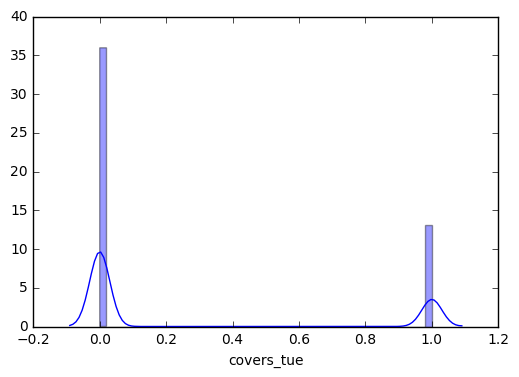

In [120]:
import pandas as pd
import seaborn as sns, numpy as np
x = pd.Series(test.loc[test['predict_correct'] == 1, 'covers_wed'], name='covers_tue')
ax = sns.distplot(x)

In [15]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [50]:
test.drop('type6', inplace=True, axis=1)

/Users/Phoebe/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [54]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test['活动赠券'], test['covers_tue'])

array([[250893, 251553],
       [471579,  87973]])

In [29]:
sum(test['covers_tue'])

339526.0

In [67]:
from pandas_ml import ConfusionMatrix
cm = ConfusionMatrix(test['covers_tue'], test['is_used'])

cm

Predicted   False    True  __all__
Actual                            
False      648766   73706   722472
True       246277   93249   339526
__all__    895043  166955  1061998

In [56]:
from pandas_ml import ConfusionMatrix
cm = ConfusionMatrix(test['type6'], test['covers_tue'])

cm

Predicted   False    True  __all__
Actual                            
False      656788  118854   775642
True        65684  220672   286356
__all__    722472  339526  1061998

In [128]:
sum(test['covers_tue'])

339526.0

In [129]:
sum(test['predict_correct'])

915489

In [142]:
results_all[results_all['testset_group2_class']==1].head()

,testset_group1_class,testset_group2_class,testset_group3_class,testset_group1_predict_prob_NotUsed,testset_group2_predict_prob_NotUsed,testset_group3_predict_prob_NotUsed,testset_group1_predict_prob_Used,testset_group2_predict_prob_Used,testset_group3_predict_prob_Used,testset_all_predict_class,...,coupon_type1_usage_rate,coupon_type6_usage_rate,coupon_used_weekend_perc,order_weekend_perc,worth_money_median,worth_money_std,InterOrder_fillna_w_start_date,InterCoup_fillna_w_start_date,Recency_fillna_w_start_date,is_used
5,1.0,1.0,1.0,0.192956,0.393543,0.300485,0.807044,0.606457,0.699515,1.0,...,1.164706,1.000000,0.166667,0.086957,-0.5,0.389087,-0.034794,0.350108,-0.437647,1.0
53,1.0,1.0,1.0,0.147052,0.298475,0.280969,0.852948,0.701525,0.719031,1.0,...,3.891892,0.800000,0.300000,0.210526,-2.0,0.787245,-0.131290,0.137531,-0.327059,1.0
54,1.0,1.0,1.0,0.147052,0.298475,0.280969,0.852948,0.701525,0.719031,1.0,...,3.891892,0.800000,0.300000,0.210526,-2.0,0.787245,-0.131290,0.137531,-0.327059,1.0
67,0.0,1.0,0.0,0.891293,0.419086,0.879403,0.108707,0.580914,0.120597,0.0,...,1.800000,0.666667,0.000000,0.076923,0.0,0.438475,-0.041786,0.640873,-0.263529,1.0
148,1.0,1.0,1.0,0.342439,0.251080,0.183677,0.657561,0.748920,0.816323,1.0,...,3.521739,1.000000,0.272727,0.180723,0.0,0.892458,-0.206562,0.274405,-0.263529,1.0
